In [1]:
# Train a CNN regression to predict the mCG level of all DMRs
import pandas as pd
import csv
import numpy as np
import time
import matplotlib.pyplot as plt
import seqlogo
from IPython.display import clear_output
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.cuda.is_available()

True

In [2]:
# Load DMR mCG levels
dmrs_mc = pd.read_csv('/cndd/emukamel/snmCSeq/DMR/Kmer_Features/Mouse_DMRs_methylation_level.csv',
                  names=['Clust%d' % i for i in range(15)], header=None, index_col=False)
dmrs_mc = torch.tensor(dmrs_mc.to_numpy(), dtype=torch.float)

ndmrs, ncelltypes = dmrs_mc.shape

In [3]:
datadir = '/cndd/emukamel/snmCSeq/DMR'
seq_fn = datadir+'/mouse_all_cluster_dms2_HighVariance.600bp.fasta'
seqs = pd.read_csv(seq_fn, index_col = False, header=None, sep="\t")
seq_lengths = [len(i) for i in seqs[1]]
max_seqlength = max(seq_lengths)


In [4]:
# One-hot encoding of the sequences
seqs[1] = seqs[1].str.upper()
acgt = 'NACGT'

acgt_to_int = dict((n,i) for i,n in enumerate(acgt))

seqs_1hot = np.zeros(shape=(seqs.shape[0],max_seqlength,len(acgt)), dtype=np.int8) 
for js,seq in enumerate(seqs[1]):
    for jlett,lett in enumerate(seq):
        seqs_1hot[js,jlett,acgt_to_int[lett]] = 1

# Remove the N
seqs_1hot = seqs_1hot[:,:,1:]
acgt = acgt[1:]

acgt_to_int = dict((n,i) for i,n in enumerate(acgt))

In [5]:
# Convert to tensor
seqs_1hot_tensor = torch.tensor(seqs_1hot)

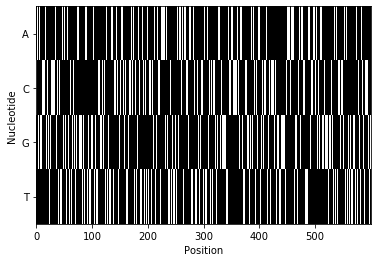

In [6]:
plt.imshow(seqs_1hot[1,:,:].transpose(), aspect='auto', cmap='gray')
plt.ylabel('Nucleotide')
plt.yticks(list(acgt_to_int.values()),list(acgt_to_int.keys()))
plt.xlabel('Position')
plt.show()

In [7]:
# Define the neural net architecture
window = max_seqlength
nfilt = 128;
filt_width = 7

# Define a class for the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(len(acgt), nfilt, filt_width)
        self.pool = nn.MaxPool1d(window-filt_width)
        self.fc1 = nn.Linear(nfilt, nfilt)
        self.fc2 = nn.Linear(nfilt, int(nfilt/2))
        self.fc3 = nn.Linear(int(nfilt/2), ncelltypes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))).squeeze()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [8]:
# ?pd.DataFrame.to_numpy
pd.__version__

'0.25.2'

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
print(torch.cuda.current_device())

cuda:0
0


In [10]:
device

device(type='cuda', index=0)

In [11]:
# # Benchmark how long the training takes. GPU seems to take ~1 s per 1000 items, CPU takes 3 s for batch_size=8. Optimal batch_size=20
# batch_size = 20

# # for log_batch_size in np.arange(3,16):
# #     batch_size = 2**log_batch_size
# for batch_size in np.arange(10,50,2):
#     net = Net()
#     criterion = nn.MSELoss()
#     optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#     if device is not "cpu":
#         net.to(device)
#     net.train
#     running_time = 0
#     X = seqs_1hot_tensor
#     # X = seqs_1hot_tensor[0:1000,:,:]
#     for epoch in range(1):  # loop over the dataset multiple times
#         running_loss = 0.0
#         permutation = torch.randperm(X.size()[0])
#         start=time.time()
#         for i in range(0, X.size()[0], batch_size):
#             indices = permutation[i:i+batch_size]
#             batch_X = X[indices,:,:].float()

#             # Input should be of size: (batch, channels, samples)
#             batch_X = torch.transpose(batch_X,2,1)
#             batch_dmrs_mc = dmrs_mc[indices]

#             # Send training data to CUDA
#             if device is not "cpu":
#                 batch_X = batch_X.to(device)
#                 batch_dmrs_mc = batch_dmrs_mc.to(device)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs = net(batch_X)
#             loss = criterion(outputs, batch_dmrs_mc)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             if (time.time()-start)>5:
#                 # print statistics
#                 running_time += time.time()-start
#                 print('[Batch size %d, Epoch %d, Item %d/%d, %3.1f%% of data] loss: %.3g; %3.3fs per 1000 items' %
#                       (batch_size, epoch + 1, i, ndmrs, 100*i/ndmrs, running_loss / 2000, 1000*running_time/i))
#                 running_loss = 0.0
#                 start = time.time()
#                 break

# print('Finished Training')

In [12]:
net = Net()
if device is not "cpu":
    net.to(torch.device(device))
criterion = nn.MSELoss()
lr = 0.1
# optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=lr)

batch_size=20
if device is not "cpu":
    net.to(device)
net.train
running_time = 0
loss_vec = corr_vec = []
nepochs = 0

In [13]:
# X = seqs_1hot_tensor
batch_size=20
X = torch.transpose(seqs_1hot_tensor.float(),2,1).float()
out_fn='tmp.CNN_trained_2_'+datetime.datetime.now().strftime('%m-%d-%y')+'.lr%3.3f.save' % (lr)
print(out_fn)


loss_test=[]
loss_train = []
corr_vec = []

tmp.CNN_trained_2_11-01-19.lr0.100.save


In [14]:
mc_file='data_INTACT/Mouse_DMRs_methylation_level.csv'
dmrs_mc = pd.read_csv(mc_file, names=['Clust%d' % i for i in range(15)], header=None, index_col=False)
dmrs_mc = torch.tensor(dmrs_mc.to_numpy(), dtype=torch.float)
dmrs_mc

tensor([[0.8448, 0.9286, 0.8721,  ..., 0.9426, 0.8919, 0.9592],
        [0.7136, 0.9643, 0.2606,  ..., 0.7849, 0.9000, 0.7671],
        [0.0870, 0.0000, 0.0306,  ..., 0.5378, 0.7806, 0.5698],
        ...,
        [0.0606, 0.4615, 0.3929,  ..., 0.0414, 0.3655, 0.3539],
        [0.9153, 0.9783, 0.9209,  ..., 0.3433, 0.4443, 0.5305],
        [0.7468, 0.1389, 0.8056,  ..., 0.5476, 0.6588, 0.6594]])

In [15]:
scheduler = optim.lr_scheduler.StepLR(optimizer, 50)

In [17]:
X = torch.transpose(seqs_1hot_tensor.float(),2,1).float()

trainfrac = 0.8
num_epochs = 500
batch_size=64

permutation = torch.randperm(X.size()[0])
ntrain = round(X.size()[0]*trainfrac)
ntest = ndmrs-ntrain
training = permutation[:ntrain]
testing = permutation[ntrain:]

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_time = 0

    start=time.time()
    nsamp=0
    running_loss = 0.0
    net.train()
    for i in range(0, len(training), batch_size):
        indices = training[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_X = X[indices,:,:]
        batch_dmrs_mc = dmrs_mc[indices]

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)
            batch_dmrs_mc = batch_dmrs_mc.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(batch_X)
        loss = criterion(outputs, batch_dmrs_mc)
        loss.backward()
        optimizer.step()

#         print('Train: i=%d, loss=%g' % (i, loss.item()))
        running_loss += loss.item()
        nsamp += 1
        if (time.time()-start)>5:
            # print statistics
            running_time += time.time()-start
            print('  [Batch size %d, Epoch %d, Item %d/%d, %3.1f%% of data] loss: %.3g; %3.3fs per 1000 items' %
                  (batch_size, epoch + 1, i, ndmrs, 100*i/ndmrs, running_loss/nsamp, 1000*running_time/i))
            start = time.time()
    loss_train.append(running_loss/nsamp)
    print(running_loss, nsamp)
            
    # Test/Validate
#     net.eval()
    running_loss_test = 0.0
    nsamp = 0
    for i in range(0, len(testing), batch_size):
        indices = testing[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_X = X[indices,:,:]
        batch_dmrs_mc = dmrs_mc[indices]

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)
            batch_dmrs_mc = batch_dmrs_mc.to(device)

        # forward + backward + optimize
        outputs = net(batch_X)
        loss = criterion(outputs, batch_dmrs_mc)

        running_loss_test += loss.item()
        nsamp += 1
    loss_test.append(running_loss_test/nsamp)
    print(running_loss_test, nsamp)

    print('*** Epoch %d/%d, %d total training epochs, loss for train: %3.6g, test: %3.6g, time=%3.3f s' %
          (epoch, num_epochs, len(loss_train), loss_train[-1], loss_test[-1], running_time))

    torch.save({
        'net_state': net.state_dict(),
        'loss_train': loss_train,
        'loss_test': loss_test,
    }, out_fn)
    print('Saved %s' % out_fn)
    
    scheduler.step()
print('Finished Training')

  [Batch size 64, Epoch 1, Item 23488/58959, 39.8% of data] loss: 0.0806; 0.213s per 1000 items
  [Batch size 64, Epoch 1, Item 46720/58959, 79.2% of data] loss: 0.0807; 0.214s per 1000 items
59.52133869379759 737
14.855570577085018 185
*** Epoch 0/500, 3 total training epochs, loss for train: 0.0807617, test: 0.0803004, time=10.012 s
Saved tmp.CNN_trained_2_11-01-19.lr0.100.save
  [Batch size 64, Epoch 2, Item 23168/58959, 39.3% of data] loss: 0.0808; 0.216s per 1000 items
  [Batch size 64, Epoch 2, Item 46144/58959, 78.3% of data] loss: 0.081; 0.217s per 1000 items
59.68378754705191 737
15.014844454824924 185
*** Epoch 1/500, 4 total training epochs, loss for train: 0.0809821, test: 0.0811613, time=10.013 s
Saved tmp.CNN_trained_2_11-01-19.lr0.100.save
  [Batch size 64, Epoch 3, Item 23232/58959, 39.4% of data] loss: 0.081; 0.216s per 1000 items
  [Batch size 64, Epoch 3, Item 46080/58959, 78.2% of data] loss: 0.0812; 0.217s per 1000 items
59.825795993208885 737
14.966995790600777 18

KeyboardInterrupt: 

In [39]:
[loss_test, loss_train]

[[0.0710276385304179,
  0.07130084371794078,
  0.07042035488581547,
  0.07070088381484403],
 [0.0710276385304179,
  0.07130084371794078,
  0.07042035488581547,
  0.07070088381484403]]

*** Epoch 75, total loss: 182.418, time=1491.180 s


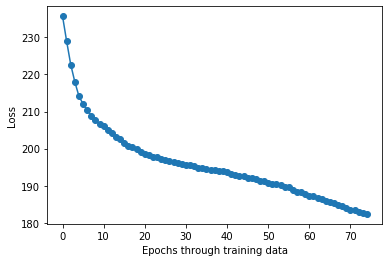

Saved CNN_trained_2_10-30-19.lr0.050.save
  [Batch size 20, Epoch 77, Item 5200/58959, 8.8% of data] loss: 0.0613; 287.150s per 1000 items
  [Batch size 20, Epoch 77, Item 10120/58959, 17.2% of data] loss: 0.0611; 147.746s per 1000 items
  [Batch size 20, Epoch 77, Item 15140/58959, 25.7% of data] loss: 0.0614; 98.890s per 1000 items
  [Batch size 20, Epoch 77, Item 19760/58959, 33.5% of data] loss: 0.0613; 75.871s per 1000 items
  [Batch size 20, Epoch 77, Item 24720/58959, 41.9% of data] loss: 0.0613; 60.728s per 1000 items
  [Batch size 20, Epoch 77, Item 29420/58959, 49.9% of data] loss: 0.0615; 51.095s per 1000 items
  [Batch size 20, Epoch 77, Item 34260/58959, 58.1% of data] loss: 0.0615; 43.935s per 1000 items


In [ ]:
for epoch in range(1000):  # loop over the dataset multiple times
    running_loss = 0.0
    permutation = torch.randperm(X.size()[0])
    start=time.time()
    nsamp=0
    for i in range(0, X.size()[0], batch_size):
        indices = permutation[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_X = X[indices,:,:]
        batch_dmrs_mc = dmrs_mc[indices]

        # Send training data to CUDA
        if device is not "cpu":
#             net.to(torch.device(device))
            batch_X = batch_X.to(device)
            batch_dmrs_mc = batch_dmrs_mc.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(batch_X)
        loss = criterion(outputs, batch_dmrs_mc)
        loss.backward()
        optimizer.step()

        print(loss.item())
        running_loss += loss.item()
        nsamp += 1
        if (time.time()-start)>2:
            # print statistics
            running_time += time.time()-start
            print('  [Batch size %d, Epoch %d, Item %d/%d, %3.1f%% of data] loss: %.3g; %3.3fs per 1000 items' %
                  (batch_size, epoch + 1, i, ndmrs, 100*i/ndmrs, running_loss/nsamp, 1000*running_time/i))
            start = time.time()
            
    # This is slow....
    #     net.to(torch.device("cpu"))
    #     dmr_hat = net(X).detach().numpy()
    #     r_overall = np.corrcoef(dmrs_mc.cpu().flatten(), dmr_hat.flatten())[0,1]
    #     corr_vec.append(r_overall)

    clear_output()
    print('*** Epoch %d, total loss: %3.6g, time=%3.3f s' %
          (nepochs, running_loss, running_time))

    loss_vec.append(running_loss)

    plt.plot(loss_vec[1:],'o-')
    plt.xlabel('Epochs through training data')
    plt.ylabel('Loss')
    plt.show()

    torch.save(net.state_dict(), fn)
    print('Saved %s' % fn)

print('Finished Training')

In [24]:
fn='CNN_trained_'+datetime.datetime.now().strftime('%m-%d-%y')+'.lr0.05.save'

torch.save(net.state_dict(), fn)
print('Saved %s' % fn)

Saved CNN_trained_10-30-19.lr0.05.save


Text(0, 0.5, 'Loss')

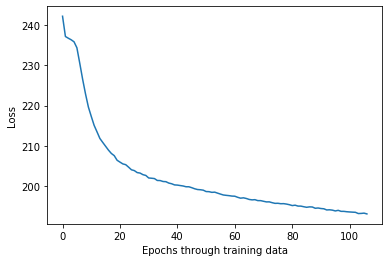

In [201]:
plt.plot(loss_vec)
plt.xlabel('Epochs through training data')
plt.ylabel('Loss')

In [25]:
# Compare predicted with actual DMR mCG level
X = torch.transpose(seqs_1hot_tensor.float(),2,1)
dmr_hat=np.zeros((ndmrs,ncelltypes))
net.eval()
net.to(torch.device("cpu"))
start = time.time()
dmr_hat = net(X).detach().numpy()
print('Done; %fs' % (time.time()-start))

Done; 7.897974s


Mean correlation r=0.521±0.082; overall r=0.590


Text(0, 0.5, 'Predicted mCG')

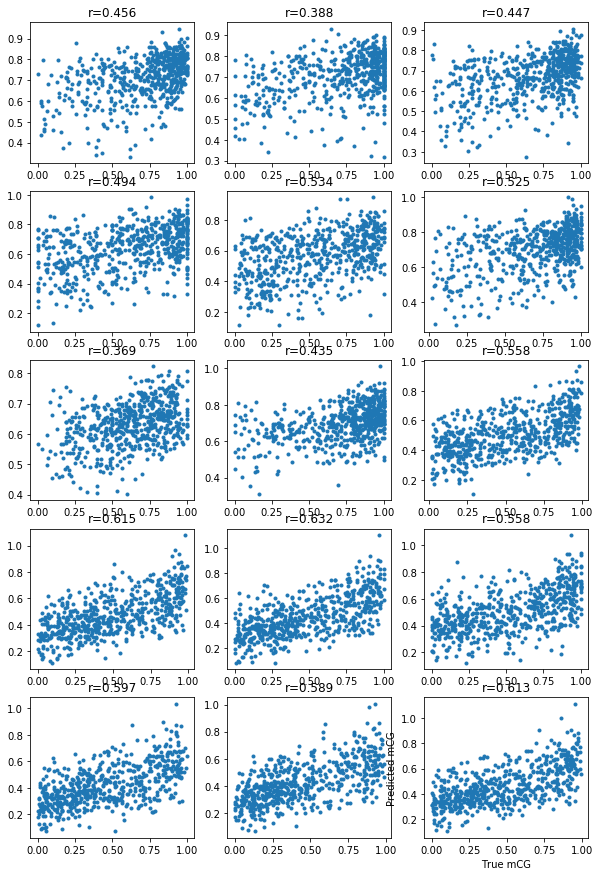

In [57]:
r_cell = np.zeros((ncelltypes,1))
for celltype in range(ncelltypes):
    cc = np.corrcoef(dmrs_mc.cpu()[:,celltype], dmr_hat[:,celltype])
    r_cell[celltype] = cc[0,1]
r_overall = np.corrcoef(dmrs_mc.cpu().flatten(), dmr_hat.flatten())[0,1]
print('Mean correlation r=%.3f±%3.3f; overall r=%.3f' % (np.mean(r_cell),np.std(r_cell), r_overall))

fig, axs = plt.subplots(5,3,figsize=(10,15))
axs = axs.flatten()
for jc in range(ncelltypes):
    plt.axes(axs[jc])
    plt.plot(dmrs_mc.cpu()[::100,jc], dmr_hat[::100,jc], '.');
    plt.title('r=%3.3f' % r_cell[jc])
    
plt.xlabel('True mCG');
plt.ylabel('Predicted mCG')


odict_keys(['conv1.weight', 'conv1.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


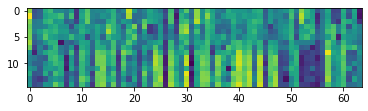

In [47]:
print(net.state_dict().keys())
plt.imshow(net.state_dict()['fc3.weight']);


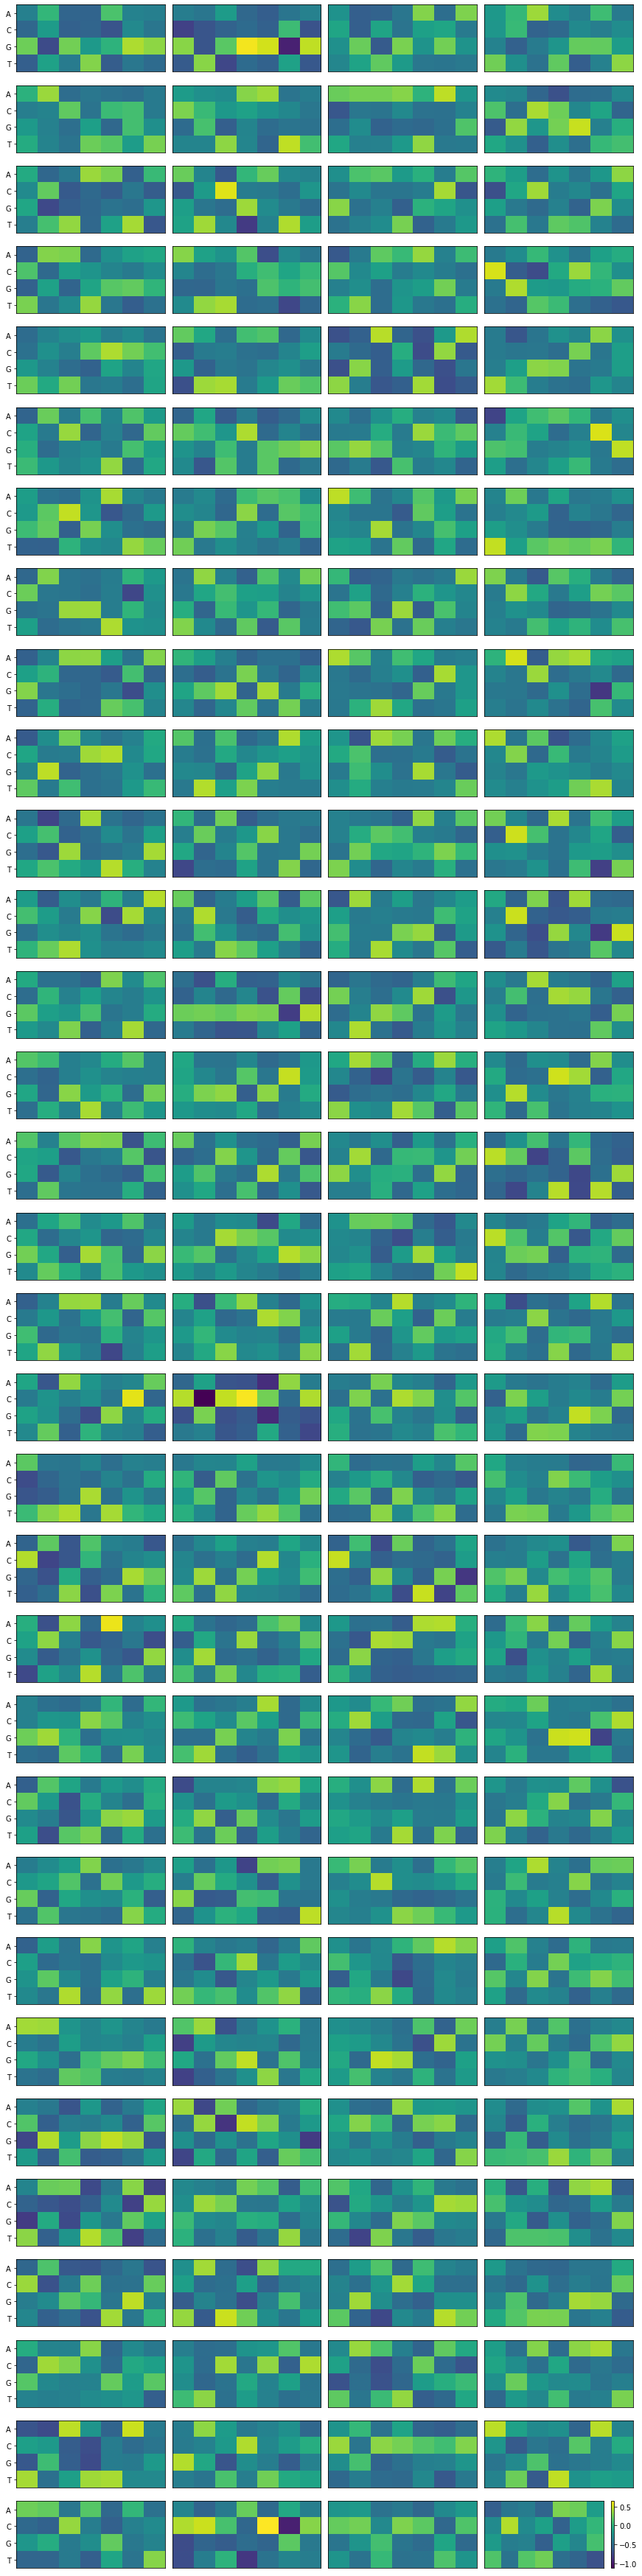

In [33]:
# Visualize the weight matrices
weights = net.state_dict()['conv1.weight'].numpy()
vmin, vmax = np.min(weights), np.max(weights)
plt.figure(figsize=(15,2*128/4))

for jfeature in range(weights.shape[0]):
    plt.subplot(128/4,4,jfeature+1,xmargin=-0.4)
    weight = weights[jfeature,:,:].squeeze()
    plt.imshow(weight, aspect='auto', vmin=vmin,vmax=vmax)
    plt.xticks([])
    if (jfeature % 4 ==0):
        plt.yticks(list(acgt_to_int.values()),list(acgt_to_int.keys()))
    else:
        plt.yticks([])
#     if jfeature>5:
#         break

plt.subplots_adjust(wspace=0.05)
plt.colorbar();
# plt.show()

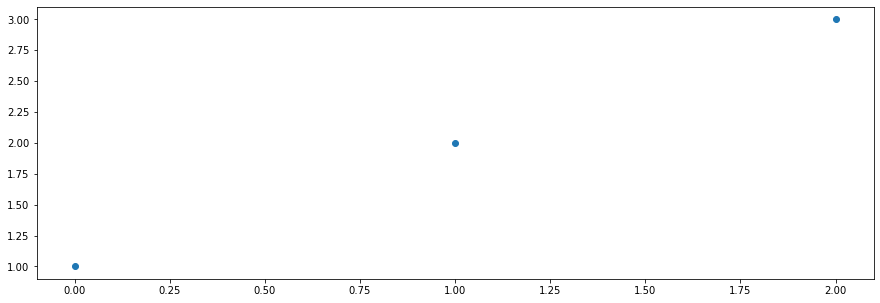

In [30]:
plt.figure(figsize=(15,5))
plt.plot([1,2,3],'o')

In [ ]:
PATH = './CNN_dmrs.state'
torch.save(net.state_dict(), PATH)

In [95]:
plt.figure(figsize=(128/4,4))


<Figure size 2304x288 with 0 Axes>

<Figure size 2304x288 with 0 Axes>